### BF Analysis & Iso-Response Contours

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

### Gaussian ball perturbation analysis

In [188]:
class lca_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    #self.save_info = "analysis_test_kurakin_targeted"
    self.overwrite_analysis_log = False

class rica_params(object):
  def __init__(self):
    self.model_type = "rica"
    self.model_name = "rica_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class sae_params(object):
  def __init__(self):
    self.model_type = "sae"
    self.model_name = "sae_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    #self.save_info = "analysis_test_kurakin_targeted"
    self.overwrite_analysis_log = False

class vae_params(object):
  def __init__(self):
    self.model_type = "vae"
    self.model_name = "vae_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    #self.save_info = "analysis_test_kurakin_targeted"
    self.overwrite_analysis_log = False

#class deep_vae_params(object):
#  def __init__(self):
#    self.model_type = "vae"
#    self.model_name = "deep_vae_mnist"
#    self.version = "0.0"
#    self.save_info = "analysis_test_carlini_targeted"
##    self.save_info = "analysis_test_kurakin_targeted"
#    self.overwrite_analysis_log = False

params_list = [lca_params(), sae_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)

In [174]:
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [138]:
dataset = ds.get_data(analyzer_list[0].model_params)
dataset = analyzer_list[0].model.preprocess_dataset(dataset, analyzer_list[0].model_params)
dataset = analyzer_list[0].model.reshape_dataset(dataset, analyzer_list[0].model_params)
target_image = dataset["train"].images[0,...]

Preprocessing: Normalized train data with maximum
Preprocessing: Normalized test data with maximum


In [139]:
# Get images that are adversarial
adv_image_set = []
prev_num_adv_images = None
for analyzer in analyzer_list:
  adv_images = analyzer.adversarial_images[0][-1]
  num_model_adv_images = adv_images.shape[0]
  if prev_num_adv_images is None:
    prev_num_adv_images = num_model_adv_images
  else:
    assert num_model_adv_images == prev_num_adv_images
  adv_images = adv_images / np.sqrt(np.sum(np.square(adv_images), axis=1, keepdims=True))
  model_adv_image_set = []
  for image_id in range(num_model_adv_images):
    model_adv_image_set.append(target_image + adv_images[image_id, :])
  adv_image_set.append(model_adv_image_set)

num_adv_images = num_model_adv_images * len(analyzer_list)

# Get images that are from the dataset
num_dataset_images = num_model_adv_images
image_set = dataset["train"].images[1:num_dataset_images+1, ...]
image_set /= np.sqrt(np.sum(np.square(image_set), axis=1, keepdims=True))
image_set += target_image[None, ...]

# Get random images
num_rand_images = num_dataset_images
noise_scale_mult = 1.0
rand_image_set = []
dimensionality = target_image.size
rand_vect = np.random.multivariate_normal(mean=[0,]*dimensionality,
  cov=np.identity(dimensionality), size=(num_rand_images))
rand_vect /= np.sqrt(np.sum(np.square(rand_vect), axis=1, keepdims=True))
rand_vect *= noise_scale_mult
for datapoint in range(num_rand_images):
  rand_image_set.append(target_image + rand_vect[datapoint, ...])
rand_image_set = np.stack(rand_image_set) 

stimulus_set = np.concatenate([target_image[None,...]]+adv_image_set+[image_set, rand_image_set])

mse = lambda x,y: np.mean(np.square(x-y))
print("Testing on", stimulus_set.shape[0]-1, "images")
print("Mean MSE =", np.mean([mse(stimulus_set[0, ...], stimulus_set[idx, ...])
  for idx in range(1, stimulus_set.shape[0])]))

Testing on 400 images
Mean MSE = 0.0012755102060195405


In [140]:
for analyzer in analyzer_list:
  evals = analyzer.evaluate_model(stimulus_set, ["inference/activity:0", "output/reconstruction:0"])
  analyzer.activations = evals["inference/activity:0"]
  analyzer.recons = evals["output/reconstruction:0"]

for analyzer in analyzer_list:
  print(analyzer.model_name, "-> recon MSE", mse(stimulus_set[0], analyzer.recons[0]))

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_768_mnist/checkpoints/lca_768_mnist_v0.0-500000
INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/vae_mnist/checkpoints/vae_mnist_v0.0-1000000
lca_768_mnist -> recon MSE 0.006985641080181422
vae_mnist -> recon MSE 0.0635885111550297


In [141]:
l2_dist = lambda x,y: np.sqrt(np.sum(np.square(x-y)))

for analyzer in analyzer_list:
  analyzer.enc_distances = [l2_dist(analyzer.activations[img_id, :], analyzer.activations[0,:])
    for img_id in range(1, analyzer.activations.shape[0])]
  analyzer.rec_distances = [l2_dist(analyzer.recons[img_id, :], analyzer.recons[0, :])
    for img_id in range(1, analyzer.recons.shape[0])]

In [142]:
for analyzer in analyzer_list:
  analyzer.model_adv_distances = {}
  for name_index, slice_index in enumerate(range(0, len(analyzer_list)*num_model_adv_images, num_model_adv_images)):
    analyzer.model_adv_distances[analyzer_list[name_index].model_name] = analyzer.rec_distances[slice_index:slice_index+num_model_adv_images]
  analyzer.dataset_distances = analyzer.rec_distances[num_adv_images:num_adv_images+num_dataset_images]
  analyzer.noise_distances = analyzer.rec_distances[num_adv_images+num_dataset_images:]

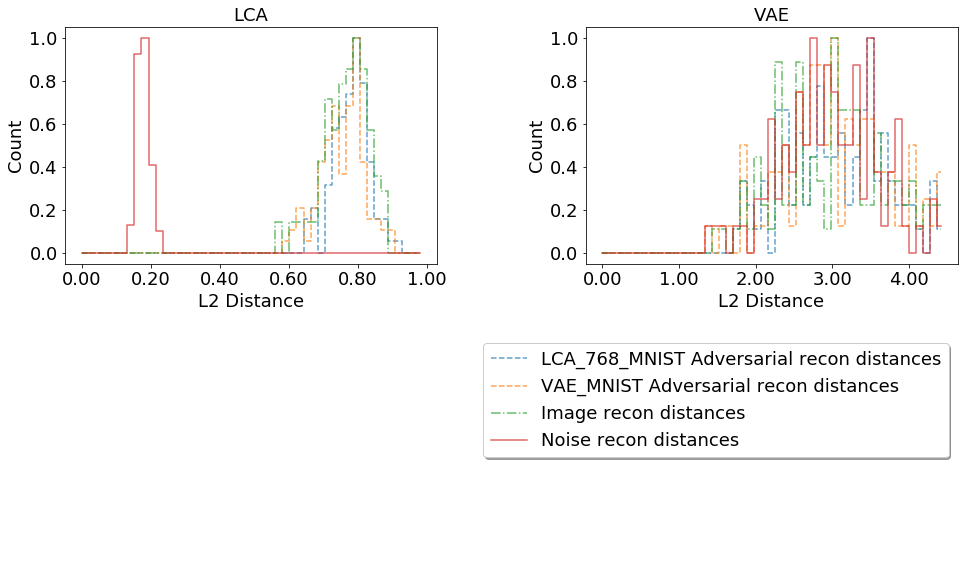

In [143]:
fontsize = 18
wspace = 0.4
hspace = 0.3
line_alpha = 0.7

fig = plt.figure(figsize=(16, 10))

gs = gridspec.GridSpec(2, len(analyzer_list), hspace=hspace, wspace=wspace)

ax_list = []
for gs_idx, analyzer in enumerate(analyzer_list):
  num_bins = 50
  min_dist = np.minimum(0.0, np.min(analyzer.noise_distances))
  max_dist = np.maximum(1.0, np.max(analyzer.noise_distances))
  bins = np.linspace(min_dist, max_dist, num_bins)
  ax_list.append(plt.subplot(gs[gs_idx]))
  analyzer.adv_rec_hist = {}
  for key in analyzer.model_adv_distances.keys():
    analyzer.adv_rec_hist[key], bin_edges = np.histogram(analyzer.model_adv_distances[key], bins=bins)
    analyzer.adv_rec_hist[key] = analyzer.adv_rec_hist[key] / np.max(analyzer.adv_rec_hist[key])
    bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
    bin_centers = bin_left + (bin_right - bin_left)/2
    ax_list[-1].plot(bin_left, analyzer.adv_rec_hist[key], alpha=line_alpha, linestyle="--",# color='k',
      drawstyle="steps-mid", label=key.upper()+" Adversarial recon distances")
  analyzer.dataset_rec_hist = np.histogram(analyzer.dataset_distances, bins=bins)[0]
  analyzer.dataset_rec_hist = analyzer.dataset_rec_hist / np.max(analyzer.dataset_rec_hist)
  analyzer.noise_rec_hist = np.histogram(analyzer.noise_distances, bins=bins)[0]
  analyzer.noise_rec_hist = analyzer.noise_rec_hist / np.max(analyzer.noise_rec_hist)

  ax_list[-1].plot(bin_left, analyzer.dataset_rec_hist, alpha=line_alpha, linestyle="-.",# color = 'r',
    drawstyle="steps-mid", label="Image recon distances")
  ax_list[-1].plot(bin_left, analyzer.noise_rec_hist, alpha=line_alpha, linestyle="-",# color='b', 
    drawstyle="steps-mid", label="Noise recon distances")
  #ax_list[-1].set_xticks(bin_left[::14], minor=False)
  #ax_list[-1].set_xticks(bin_left[::7], minor=True)
  ax_list[-1].xaxis.set_major_formatter(FormatStrFormatter("%0.2f"))
  ax_list[-1].set_xlabel("L2 Distance", fontsize=fontsize)
  ax_list[-1].set_ylabel("Count", fontsize=fontsize)
  ax_list[-1].set_title(analyzer.model_params.model_type.upper(), fontsize=fontsize)
  ax_list[-1].tick_params("both", labelsize=fontsize)

bottom_row_ax = pf.clear_axis(plt.subplot(gs[gs_idx+1:]))
h, l = ax_list[-1].get_legend_handles_labels()
bottom_row_ax.legend(h, l, fontsize=fontsize, fancybox=True, shadow=True)#, bbox_to_anchor=(1, 0.8))

plt.show()

for analyzer in analyzer_list:
  fig.savefig(analyzer.analysis_out_dir+"/vis/network_noise_perturbation_hist.png")

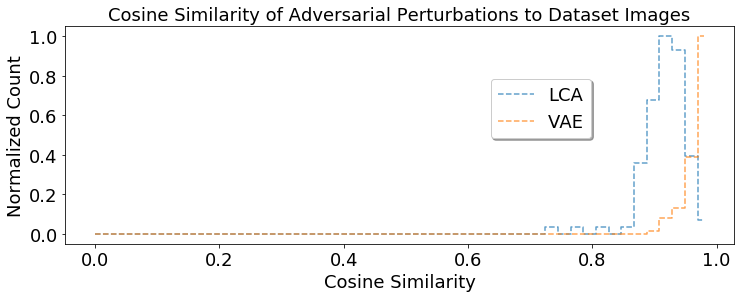

In [144]:
num_bins = 50
min_dist = 0.0
max_dist = 1.0
bins = np.linspace(min_dist, max_dist, num_bins)

fig, ax = plt.subplots(1, figsize=(12,4))

for analyzer in analyzer_list:
  #cos_similarity = analyzer.adversarial_target_pert_cos_similarities[0][-1]
  #cos_similarity = analyzer.adversarial_target_adv_cos_similarities[0][-1]
  #cos_similarity = analyzer.adversarial_input_pert_cos_similarities[0][-1]
  cos_similarity = analyzer.adversarial_input_adv_cos_similarities[0][-1]
  num_bins = 50
  min_dist = np.minimum(0.0, np.min(cos_similarity))
  max_dist = np.maximum(1.0, np.max(cos_similarity))
  analyzer.dist_hist, bin_edges = np.histogram(cos_similarity, bins=bins)
  analyzer.dist_hist = analyzer.dist_hist / np.max(analyzer.dist_hist)
  analyzer.dist_mean = np.mean(cos_similarity)
  analyzer.dist_std = np.std(cos_similarity)
  bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
  bin_centers = bin_left + (bin_right - bin_left)/2
  ax.plot(bin_left, analyzer.dist_hist, alpha=line_alpha, linestyle="--", #color = 'k',
    drawstyle="steps-mid", label=analyzer.model_params.model_type.upper())
  ax.set_xlabel("", fontsize=fontsize)
  ax.set_ylabel("Normalized Count", fontsize=fontsize)
  
ax.set_xlabel("Cosine Similarity", fontsize=fontsize)
ax.set_ylabel("Normalized Count", fontsize=fontsize)
title = ("Cosine Similarity of Adversarial Perturbations to Dataset Images")
#sensitivity_index = (lca_dist_mean - sae_dist_mean) / np.sqrt(0.5 * (lca_dist_std**2 + sae_dist_std**2))
#title = ("Cosine Similarity of Adversarial Examples to Dataset Images\n"
#         +"Sensitivity Index = "+str(np.round(sensitivity_index, decimals=2)))
ax.set_title(title, fontsize=fontsize)
ax.set_xlabel("Cosine Similarity", fontsize=fontsize)
ax.set_ylabel("Normalized Count", fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)
ax.legend(fontsize=fontsize, fancybox=True, shadow=True, bbox_to_anchor=(0.8, 0.8))
plt.show()

for analyzer in analyzer_list:
  fig.savefig(analyzer.analysis_out_dir+"/vis/cosyne_similarity.png", transparent=True, bbox_inches="tight", pad_inches=0.01)

### END Gaussian ball perturbation analysis

In [175]:
for analyzer in analyzer_list:
  analyzer.neuron_angles = analyzer.neuron_angles(analyzer.bf_stats) * (180/np.pi)

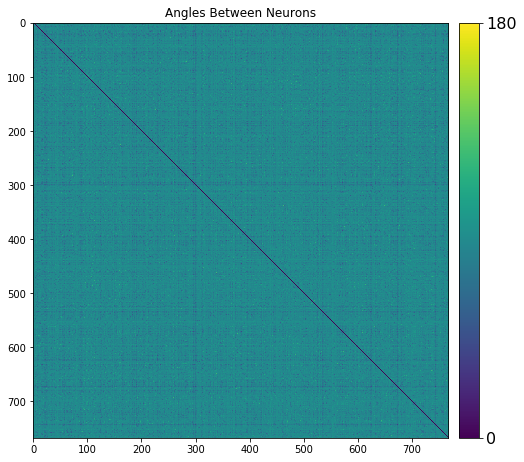

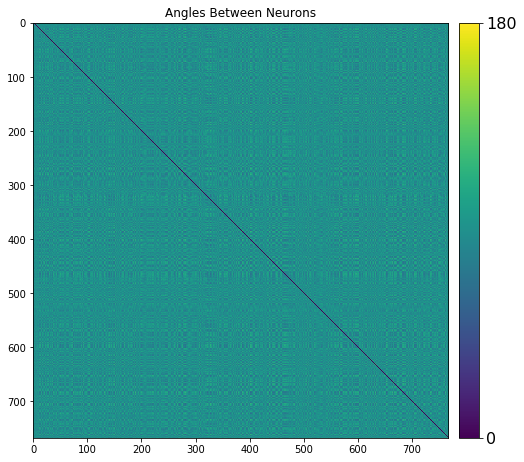

In [176]:
for analyzer in analyzer_list:
  angle_heatmap_fig = pf.plot_weight_angle_heatmap(analyzer.neuron_angles, angle_min=0, angle_max=180,
    title="Angles Between Neurons", figsize=(8,8))
  angle_heatmap_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_heatmap.png")

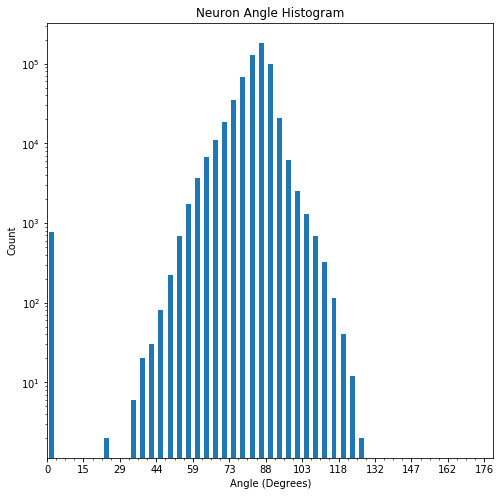

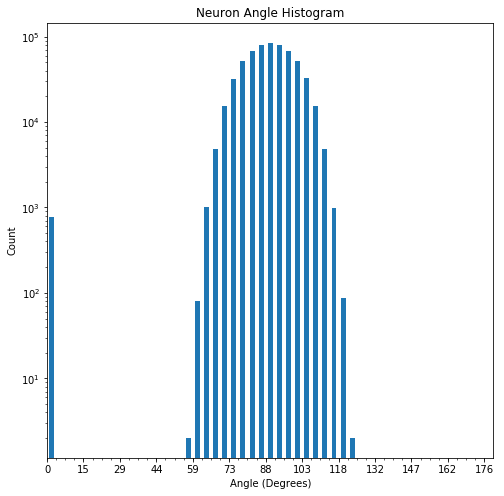

In [177]:
for analyzer in analyzer_list:
  angle_hist_fig = pf.plot_weight_angle_histogram(analyzer.neuron_angles, num_bins=50, angle_min=0, angle_max=180,
    figsize=(8,8))
  angle_hist_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_histogram.png")

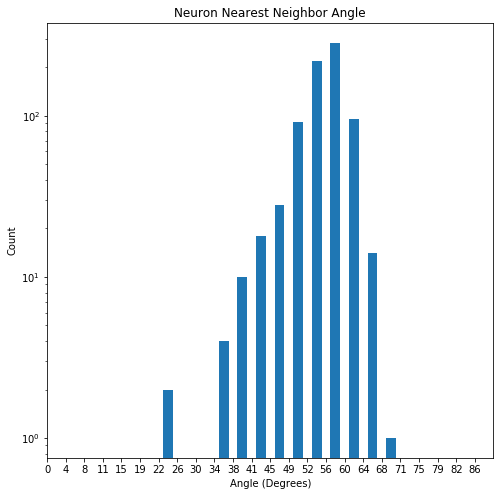

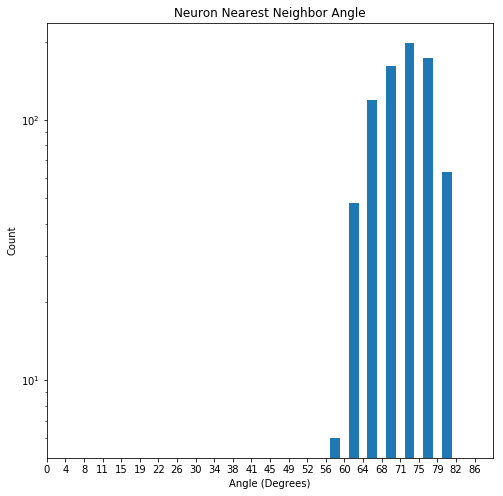

In [178]:
for analyzer in analyzer_list:
  angle_neighbor_fig = pf.plot_weight_nearest_neighbor_histogram(analyzer.neuron_angles, num_bins=25, angle_min=0,
    angle_max=90, figsize=(8,8))
  angle_neighbor_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_neighbor_histogram.png")

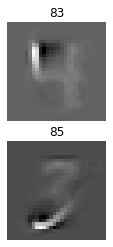

num vectors =  3430
min angle =  50.04174295412443  rad
min angle is at index  1328
BF indices = [ 83 ,  85 ]
vector angle	=  1.5756582021713257  rad
		=  90.27856493958797  deg
bf0 norm =  1.0
bf1 norm =  0.9999999


In [180]:
model_index = 0
analyzer = analyzer_list[model_index]

#min_angle = 0.5
#max_angle = 50

min_angle = 50
max_angle = 60

#min_angle = 89
#max_angle = 91

#min_angle = 100
#max_angle = 180

vectors = np.argwhere(np.logical_and(analyzer.neuron_angles<max_angle,
  analyzer.neuron_angles>min_angle))

if vectors.shape[0] > 0:
  vector_id = 2
  analyzer.bf_id0 = 83#vectors[vector_id, 0] # RICA 83, 85
  analyzer.bf_id1 = 85#vectors[vector_id, 1]
  fig, ax = plt.subplots(2)
  ax[0] = pf.clear_axis(ax[0])
  ax[0].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
  ax[0].set_title(str(analyzer.bf_id0))
  ax[1] = pf.clear_axis(ax[1])
  ax[1].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
  ax[1].set_title(str(analyzer.bf_id1))
  plt.show()

  analyzer.bf0 = analyzer.bf_stats["basis_functions"][analyzer.bf_id0].reshape(
    (analyzer.model_params.num_pixels))
  analyzer.bf1 = analyzer.bf_stats["basis_functions"][analyzer.bf_id1].reshape(
    (analyzer.model_params.num_pixels))
  analyzer.bf0_norm = np.linalg.norm(analyzer.bf0)
  analyzer.bf1_norm = np.linalg.norm(analyzer.bf1)
  analyzer.bf0 = analyzer.bf0 / analyzer.bf0_norm
  analyzer.bf1 = analyzer.bf1 / analyzer.bf1_norm
  print("num vectors = ", vectors.shape[0])
  print("min angle = ", np.min(analyzer.neuron_angles[vectors[:,0], vectors[:,1]]), " rad")
  print("min angle is at index ", np.argmin(analyzer.neuron_angles[vectors[:,0], vectors[:,1]]))
  print("BF indices = [",analyzer.bf_id0,", ",analyzer.bf_id1,"]")
  print("vector angle\t= ", analyzer.neuron_angles[analyzer.bf_id0, analyzer.bf_id1]*(np.pi/180),
    " rad\n\t\t= ", analyzer.neuron_angles[analyzer.bf_id0, analyzer.bf_id1], " deg")
  print("bf0 norm = ", analyzer.bf0_norm)
  print("bf1 norm = ", analyzer.bf1_norm)
else:
  assert False

In [181]:
num_imgs = int(228**2)
x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X_mesh.reshape(num_imgs), Y_mesh.reshape(num_imgs)], axis=1)

for analyzer in analyzer_list:
  analyzer.proj_datapoints = proj_datapoints
  analyzer.proj_matrix, v = analyzer.bf_projections(analyzer.bf0, analyzer.bf1)
  analyzer.proj_neuron0 = np.dot(analyzer.proj_matrix, analyzer.bf0).T
  analyzer.proj_neuron1 = np.dot(analyzer.proj_matrix, analyzer.bf1).T
  analyzer.proj_v = np.dot(analyzer.proj_matrix, v).T
  
  datapoints = np.stack([np.dot(analyzer.proj_matrix.T, analyzer.proj_datapoints[data_id,:])
    for data_id in range(num_imgs)]) #inject
  datapoints, orig_shape = dp.reshape_data(datapoints, flatten=False)[:2]
  datapoints = {"test": Dataset(datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
  params={"whiten_data":analyzer.model_params.whiten_data}
  if params["whiten_data"]:
    params["whiten_method"] = analyzer.model_params.whiten_method
  datapoints = analyzer.model.preprocess_dataset(datapoints, params=params)
  datapoints = analyzer.model.reshape_dataset(datapoints, analyzer.model_params)
  datapoints["test"].images /= np.max(np.abs(datapoints["test"].images))
  datapoints["test"].images *= analyzer.analysis_params.input_scale
  analyzer.vis_adv_datapoints = datapoints

In [182]:
for analyzer in analyzer_list:
  activations = analyzer.compute_activations(analyzer.vis_adv_datapoints["test"].images)
  activity_max = np.amax(np.abs(activations)) # Rescale between -1 and 1
  analyzer.norm_activity = activations / (activity_max + 0.00001)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_768_mnist/checkpoints/lca_768_mnist_v0.0-500000
INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/rica_mnist/checkpoints/rica_mnist_v0.0-1


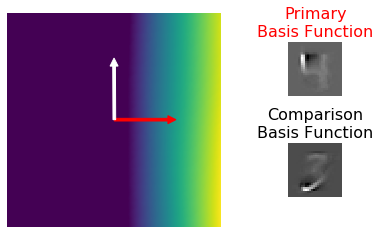

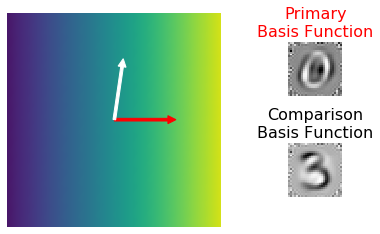

In [187]:
for analyzer in analyzer_list:
  num_plots_y = 1
  num_plots_x = 2
  gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
  fig = plt.figure(figsize=(6,6))
  curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
  #cmap = plt.get_cmap('tab20b')
  cmap = plt.get_cmap('viridis')
  vmin = np.floor(np.min(analyzer.norm_activity))#0.0
  vmax = np.ceil(np.max(analyzer.norm_activity))#1.0
  
  #pts = curve_ax.scatter(analyzer.proj_datapoints[:,0], analyzer.proj_datapoints[:,1],
  #  vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.5, c=analyzer.norm_activity[:, analyzer.bf_id0], s=5.0)
  
  levels = 5
  contsf = curve_ax.contourf(X_mesh, Y_mesh,
    analyzer.norm_activity[:,analyzer.bf_id0].reshape(int(np.sqrt(num_imgs)),
    int(np.sqrt(num_imgs))), levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)
  
  curve_ax.arrow(0, 0, analyzer.proj_neuron0[0].item(),
    analyzer.proj_neuron0[1].item(), width=0.05, head_width=0.15,
    head_length=0.15, fc='r', ec='r')
  curve_ax.arrow(0, 0, analyzer.proj_neuron1[0].item(),
    analyzer.proj_neuron1[1].item(), width=0.05, head_width=0.15,
    head_length=0.15, fc='w', ec='w')
  #curve_ax.arrow(0, 0, analyzer.proj_v[0].item(), analyzer.proj_v[1].item(), width=0.05, head_width=0.15,
  # head_length=0.15, linestyle="-.", fc='k', ec='k')
  
  #curve_ax.set_title("Angle = "+"{:.2f}".format(analyzer.neuron_angles[bf_id0, bf_id1])+" deg", fontsize=16)
  curve_ax.set_ylim([-2, 2.0])
  curve_ax.set_xlim([-2, 2.0])
  curve_ax.set_aspect("equal")
  #cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
  #cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])
  
  gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.55)
  bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
  bf1_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
  bf1_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
  bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
  bf2_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
  bf2_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)
  fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(analyzer.bf_id0)+"_bf1id"+str(analyzer.bf_id1)+".png",
    transparent=True, bbox_inches="tight", pad_inches=0.01)
  plt.show()

### END REFACTOR

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_768_mnist/checkpoints/lca_768_mnist_v0.0-500000
num nonzero for bf1:  5
num nonzero for bf2:  3


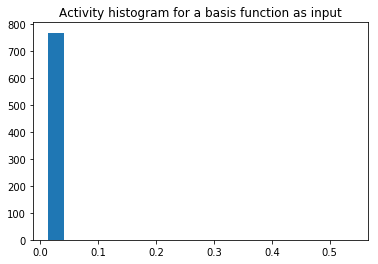

In [126]:
var_names = ["inference/activity:0"]
test_datapoints = analyzer.analysis_params.input_scale*np.squeeze(np.stack([bf1, bf2]))
test_activations = analyzer.evaluate_model(test_datapoints, var_names)["inference/activity:0"]
print("num nonzero for bf1: ", np.count_nonzero(test_activations[0,:]))
print("num nonzero for bf2: ", np.count_nonzero(test_activations[1,:]))
fig, ax = plt.subplots(1)
ax.hist(test_activations[1,:], rwidth=0.5)
ax.set_title("Activity histogram for a basis function as input")
plt.show()

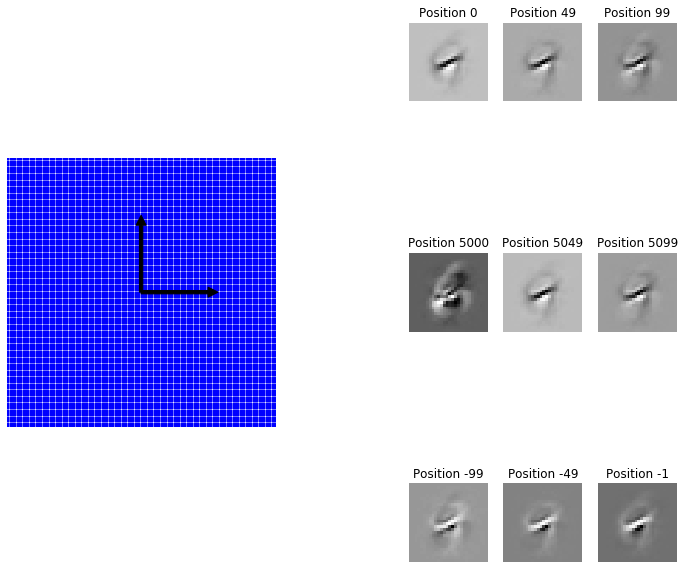

In [127]:
#def plot_iso_response_contours(cmap, save_filename)
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5)#, width_ratios=[4, 1])
fig = plt.figure(figsize=(12, 12))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
cmap = plt.get_cmap('tab20b')

pts = curve_ax.scatter(proj_datapoints[:,0], proj_datapoints[:,1], cmap=cmap, c="blue", s=0.5)
curve_ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
#curve_ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15,
#  head_length=0.15, fc='r', ec='r')
curve_ax.arrow(0, 0, proj_v[0].item(), proj_v[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
curve_ax.set_ylim([-2.0, 2.0])
curve_ax.set_xlim([-2.0, 2.0])
curve_ax.set_aspect("equal")

#img_idx = -1
#pts = curve_ax.scatter(proj_datapoints[img_idx, 0], proj_datapoints[img_idx, 1], cmap=cmap, c="red", s=50.0)

def plt_img(axis, img_idx):
  axis.imshow(datapoints["test"].images[img_idx, ...].reshape((int(np.sqrt(analyzer.model_params.num_pixels)),
    int(np.sqrt(analyzer.model_params.num_pixels)))), cmap="Greys_r")
  axis.set_title("Position "+str(img_idx))
  return axis

img_idx = 0
gs2 = gridspec.GridSpecFromSubplotSpec(3, 3, gs1[1])#, wspace=2, hspace=-0.2)
bf1_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[0])), img_idx)

img_idx = 49
bf2_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[1])), img_idx)

img_idx = 99
bf3_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[2])), img_idx)

img_idx = 5000
bf4_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[3])), img_idx)

img_idx = 5049
bf5_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[4])), img_idx)

img_idx = 5099
bf6_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[5])), img_idx)

img_idx = -99
bf7_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[6])), img_idx)

img_idx = -49
bf8_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[7])), img_idx)

img_idx = -1
bf9_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[8])), img_idx)

fig.savefig(analyzer.analysis_out_dir+"/vis/projection_visualization"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [128]:
x_target = x_pts[int(6*np.sqrt(num_imgs)/8)] # find a location to take a slice
slice_indices = np.where(proj_datapoints[:,0]==x_target)[0]
x_vals = proj_datapoints[slice_indices,:][:,1] # slice grid

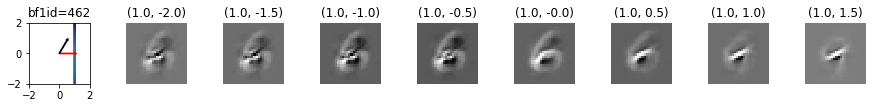

In [129]:
num_comparison_points = 8
num_plots_y = 1
num_plots_x = 1+num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.6)
fig = plt.figure(figsize=(15, 6))
for yid in range(num_plots_y):
  ax1 = fig.add_subplot(gs1[yid, 0])

  cmap = plt.get_cmap('viridis')
  vmin = 0.0
  vmax = 1.0
  rank_indices = np.argsort(norm_activity[slice_indices, bf_id0])
  slice_datapoints = proj_datapoints[slice_indices,:]
  pts = ax1.scatter(slice_datapoints[rank_indices,0],
    slice_datapoints[rank_indices,1], vmin=vmin, vmax=vmax,
    cmap=cmap, c=norm_activity[slice_indices, bf_id0][rank_indices], s=1.0)
  ax1.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
  ax1.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')
  ax1.set_xlim([-2,2])
  ax1.set_ylim([-2,2])
  ax1.set_aspect("equal")
  ax1.set_title("bf1id="+str(bf_id1))

  y_indices = np.arange(slice_indices.size)[::int(slice_indices.size/num_comparison_points)]
  if y_indices.size < num_comparison_points:
    y_indices.append(-1)
  for pid, xid in enumerate(range(1, num_plots_x)):
    ax = pf.clear_axis(fig.add_subplot(gs1[yid, xid]))
    images = datapoints["test"].images[slice_indices, :]
    ax.imshow(images[y_indices[pid], :].reshape([int(np.sqrt(analyzer.model_params.num_pixels)),
      int(np.sqrt(analyzer.model_params.num_pixels))]), cmap="Greys_r")
    subfig_title = ("({:.1f}, ".format(proj_datapoints[slice_indices,:][y_indices[pid],0])
      +"{:.1f})".format(proj_datapoints[slice_indices,:][y_indices[pid],1]))
    ax.set_title(subfig_title)
fig.savefig(analyzer.analysis_out_dir+"/vis/single_slice_example_bf0id"+str(bf_id0)+".png")
plt.show()

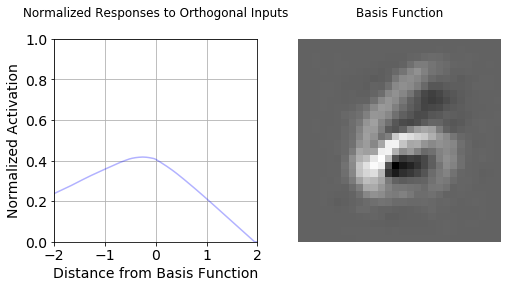

In [130]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].plot(x_vals, norm_activity[slice_indices, bf_id0], color='b', alpha=0.3) # x_vals in the 2-D grid are plotted along the x axis
ax[0].set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax[0].set_ylabel("Normalized Activation", fontsize=14)
ax[0].set_xlabel("Distance from Basis Function", fontsize=14)
ax[0].grid(True)
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlim([np.min(x_vals), np.max(x_vals)])
ax[0].set_aspect((np.max(x_vals)-np.min(x_vals)))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[1].set_title("Basis Function", y=1.08)
fig.savefig(analyzer.analysis_out_dir+"/vis/bf_example_curvature_bf0id"+str(bf_id0)+".png")
plt.show()

In [131]:
"""
* Compute a unit vector that is in the same plane as a given basis function pair (B1,B2) and is orthogonal to B1, where B1 is the target basis for comparison and B2 is selected from all other bases.
* Construct a line of data points in this plane
* Project the data points into image space, compute activations, plot activations
"""
pop_num_imgs = 100

orthogonal_list = [idx for idx in range(analyzer.bf_stats["num_outputs"]) if idx != bf_id0]#[bf_id1]
num_orthogonal = len(orthogonal_list)

pop_x_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_y_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_X, pop_Y = np.meshgrid(pop_x_pts, pop_y_pts)
pop_proj_datapoints = np.stack([pop_X.reshape(pop_num_imgs**2), pop_Y.reshape(pop_num_imgs**2)], axis=1) # construct a grid
x_target = pop_x_pts[int(6*pop_num_imgs/8)] # find a location to take a slice
slice_indices = np.where(pop_proj_datapoints[:,0]==x_target)[0]
pop_proj_datapoints = pop_proj_datapoints[slice_indices,:] # slice grid

pop_datapoints = [None,]*num_orthogonal
pop_proj_neurons = [None,]*num_orthogonal
#proj_matrix_list = []
for pop_idx, tmp_bf_id1 in enumerate(orthogonal_list):
  tmp_bf2 = analyzer.bf_stats["basis_functions"][tmp_bf_id1].reshape((analyzer.model_params.num_pixels))
  tmp_bf2 /= np.linalg.norm(tmp_bf2)
  tmp_proj_matrix, v = analyzer.bf_projections(bf1, tmp_bf2) 
  #if pop_idx > 0: # Check to make sure you're not duplicating any of the orth planes
  #  for comp_proj_matrix in proj_matrix_list:
  #    if np.allclose(tmp_proj_matrix, comp_proj_matrix):
  #      assert False
  #proj_matrix_list.append(tmp_proj_matrix)
  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1).T, np.dot(tmp_proj_matrix, tmp_bf2).T)
  pop_datapoints[pop_idx] = np.dot(pop_proj_datapoints, tmp_proj_matrix)#[slice_indices,:]

pop_datapoints = np.reshape(np.stack(pop_datapoints, axis=0),
  [num_orthogonal*pop_num_imgs, analyzer.model_params.num_pixels])

pop_datapoints = dp.reshape_data(pop_datapoints, flatten=False)[0]
pop_datapoints = {"test": Dataset(pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
pop_datapoints = analyzer.model.preprocess_dataset(pop_datapoints,
  params={"whiten_data":analyzer.model_params.whiten_data,
  "whiten_method":analyzer.model_params.whiten_method})
pop_datapoints = analyzer.model.reshape_dataset(pop_datapoints, analyzer.model_params)
pop_datapoints["test"].images /= np.max(np.abs(pop_datapoints["test"].images))
pop_datapoints["test"].images *= analyzer.analysis_params.input_scale

In [132]:
"""
* Construct the set of unit-length bases that are orthogonal to B1 (there should be B1.size-1 of them)
* Construct a line of data points in each plane defined by B1 and a given orthogonal basis
* Project the data points into image space, compute activations, plot activations
"""
def find_orth(matrix):
  """
  https://stackoverflow.com/questions/50660389/generate-a-vector-that-is-orthogonal-to-a-set-of-other-vectors-in-any-dimension
  """
  rand_vect = np.random.rand(matrix.shape[0], 1)
  new_matrix = np.hstack((matrix, rand_vect))
  candidate_vect = np.zeros(matrix.shape[1]+1)
  candidate_vect[-1] = 1
  orth_vect = np.linalg.lstsq(new_matrix.T, candidate_vect, rcond=None)[0]
  orth_vect = np.squeeze((orth_vect  / np.linalg.norm(orth_vect)).T) 
  return orth_vect

rand_pop_num_imgs = 100

rand_num_orthogonal = analyzer.bf_stats["num_inputs"]-1

pop_x_pts = np.linspace(-2.0, 2.0, int(rand_pop_num_imgs))
pop_y_pts = np.linspace(-2.0, 2.0, int(rand_pop_num_imgs))
pop_X, pop_Y = np.meshgrid(pop_x_pts, pop_y_pts)
rand_pop_proj_datapoints = np.stack([pop_X.reshape(rand_pop_num_imgs**2), pop_Y.reshape(rand_pop_num_imgs**2)], axis=1) # construct a grid
x_target = pop_x_pts[int(6*rand_pop_num_imgs/8)] # find a location to take a slice
slice_indices = np.where(rand_pop_proj_datapoints[:,0]==x_target)[0]
rand_pop_proj_datapoints = rand_pop_proj_datapoints[slice_indices,:] # slice grid

orth_col_matrix = bf1.T[:,None]
rand_pop_datapoints = [None,]*rand_num_orthogonal
pop_proj_neurons = [None,]*rand_num_orthogonal
for pop_idx in range(rand_num_orthogonal):
  v = find_orth(orth_col_matrix)
  tmp_proj_matrix = np.stack([bf1, v], axis=0)
  orth_col_matrix = np.append(orth_col_matrix, v[:,None], axis=1)
  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1).T, np.dot(tmp_proj_matrix, tmp_bf2).T)
  rand_pop_datapoints[pop_idx] = np.dot(rand_pop_proj_datapoints, tmp_proj_matrix)#[slice_indices,:]

rand_pop_datapoints = np.reshape(np.stack(rand_pop_datapoints, axis=0),
  [rand_num_orthogonal*rand_pop_num_imgs, analyzer.model_params.num_pixels])

rand_pop_datapoints = dp.reshape_data(rand_pop_datapoints, flatten=False)[0]
rand_pop_datapoints = {"test": Dataset(rand_pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
rand_pop_datapoints = analyzer.model.preprocess_dataset(rand_pop_datapoints,
  params={"whiten_data":analyzer.model_params.whiten_data,
  "whiten_method":analyzer.model_params.whiten_method})
rand_pop_datapoints = analyzer.model.reshape_dataset(rand_pop_datapoints, analyzer.model_params)
rand_pop_datapoints["test"].images /= np.max(np.abs(rand_pop_datapoints["test"].images))
rand_pop_datapoints["test"].images *= analyzer.analysis_params.input_scale

if all(np.abs(np.dot(bf1, col)) < 10e-9 for col in orth_col_matrix[:,1:].T):
    print("Success")
else:
    print("Failure")

Success


In [133]:
pop_activations = analyzer.compute_activations(pop_datapoints["test"].images)[:, bf_id0]
pop_activations = pop_activations.reshape([num_orthogonal, pop_num_imgs])
pop_norm_activity = pop_activations / np.amax(np.abs(pop_activations))

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_768_mnist/checkpoints/lca_768_mnist_v0.0-500000


In [134]:
rand_pop_activations = analyzer.compute_activations(rand_pop_datapoints["test"].images)[:, bf_id0]
rand_pop_activations = rand_pop_activations.reshape([rand_num_orthogonal, rand_pop_num_imgs])
rand_pop_norm_activity = rand_pop_activations / np.amax(np.abs(rand_pop_activations))

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_768_mnist/checkpoints/lca_768_mnist_v0.0-500000


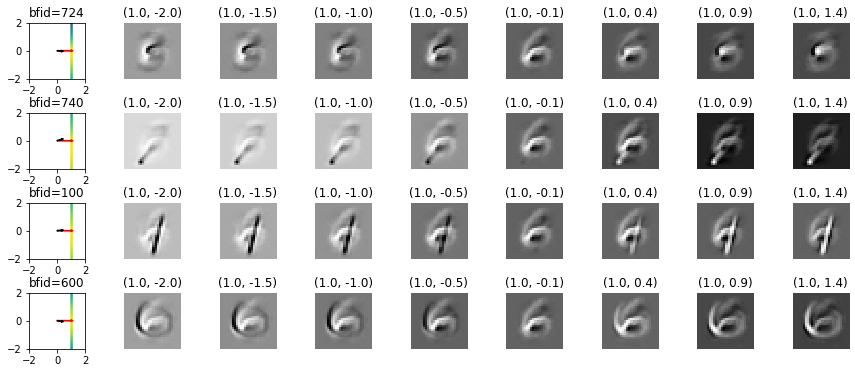

In [135]:
num_comparison_points = 8
num_plots_y = 4
num_plots_x = 1+num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(15, 6))
for yid in range(num_plots_y):
  orthog_idx = np.random.choice(np.arange(num_orthogonal), replace=False)
  ax1 = fig.add_subplot(gs1[yid, 0])
  pop_orthog_activity = pop_norm_activity[orthog_idx, :] 

  cmap = plt.get_cmap('viridis')
  
  vmin = np.floor(np.min(pop_orthog_activity))
  vmax = np.ceil(np.max(pop_orthog_activity))
  rank_indices = np.argsort(pop_orthog_activity)
  pts = ax1.scatter(pop_proj_datapoints[rank_indices,0], pop_proj_datapoints[rank_indices,1],
    vmin=vmin, vmax=vmax, cmap=cmap, c=pop_orthog_activity[rank_indices], s=1.0)
  ax1.arrow(0, 0, pop_proj_neurons[orthog_idx][0][0].item(), pop_proj_neurons[orthog_idx][0][1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
  ax1.arrow(0, 0, pop_proj_neurons[orthog_idx][1][0].item(), pop_proj_neurons[orthog_idx][1][1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')
  ax1.set_xlim([-2,2])
  ax1.set_ylim([-2,2])
  ax1.set_aspect("equal")
  ax1.set_title("bfid="+str(orthogonal_list[orthog_idx]))

  y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
  if y_indices.size < num_comparison_points:
    y_indices.append(-1)
  for pid, xid in enumerate(range(1, num_plots_x)):
    ax = pf.clear_axis(fig.add_subplot(gs1[yid, xid]))
    imid = np.ravel_multi_index((orthog_idx, y_indices[pid]), (num_orthogonal, pop_num_imgs))
    ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([int(np.sqrt(analyzer.model_params.num_pixels)),
      int(np.sqrt(analyzer.model_params.num_pixels))]), cmap="Greys_r")
    subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
      +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
    ax.set_title(subfig_title)
fig.savefig(analyzer.analysis_out_dir+"/vis/orthogonal_slice_examples_bf0id"+str(bf_id0)+".png")
plt.show()

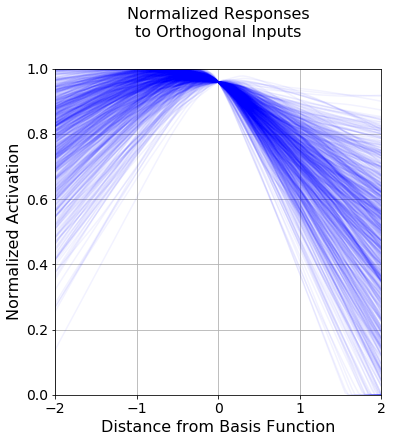

In [136]:
fig, ax = plt.subplots(1, figsize=(6,6))
for orthog_idx in range(num_orthogonal):
 ax.plot(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx, :], color='b', alpha=0.05)
ax.set_title("Normalized Responses\nto Orthogonal Inputs", y=1.08, fontsize=16)
ax.set_ylabel("Normalized Activation", fontsize=16)
ax.set_xlabel("Distance from Basis Function", fontsize=16)
ax.grid(True)
ax.set_ylim([0.0, 1.0])
ax.set_xlim([np.min(x_vals), np.max(x_vals)])
for tick in ax.xaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
ax.set_aspect((np.max(x_vals)-np.min(x_vals)))#/(np.max(pop_norm_activity)-np.min(pop_norm_activity)))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/bf_curvatures_bf0id"+str(bf_id0)+".png", transparent=True,
  bbox_inches="tight", pad_inches=0.01)
plt.show()

In [137]:
coeffs = [np.polynomial.polynomial.polyfit(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx,:], deg=2)
  for orthog_idx in range(num_orthogonal)]
fits = [np.polynomial.polynomial.polyval(pop_proj_datapoints[:,1], coeff) for coeff in coeffs]
curvatures = [np.polyder(fit, m=2) for fit in fits]

In [138]:
rand_coeffs = [np.polynomial.polynomial.polyfit(rand_pop_proj_datapoints[:,1], rand_pop_norm_activity[orthog_idx,:],
  deg=2) for orthog_idx in range(rand_num_orthogonal)]
rand_fits = [np.polynomial.polynomial.polyval(rand_pop_proj_datapoints[:,1], coeff) for coeff in rand_coeffs]
rand_curvatures = [np.polyder(fit, m=2) for fit in rand_fits]

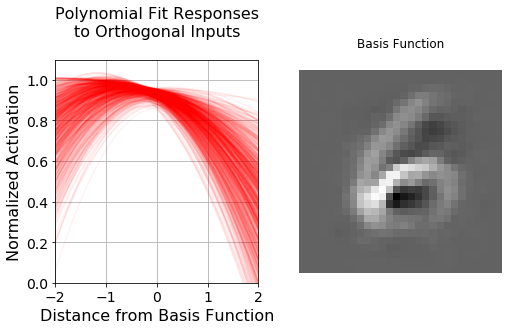

In [139]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
  ax[0].plot(pop_proj_datapoints[:,1], fits[orthog_idx], color='r', alpha=0.05)
ax[0].set_title("Polynomial Fit Responses\nto Orthogonal Inputs", y=1.08, fontsize=16)
ax[0].set_ylabel("Normalized Activation", fontsize=16)
ax[0].set_xlabel("Distance from Basis Function", fontsize=16)
for tick in ax[0].xaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
for tick in ax[0].yaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
ax[0].grid(True)
ax[0].set_ylim([0.0, 1.1])
ax[0].set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax[0].set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[1].set_title("Basis Function", y=1.08)
fig.savefig(analyzer.analysis_out_dir+"/vis/fit_curvatures_bf0id"+str(bf_id0)+".png")
plt.show()

In [158]:
[np.amin(curvatures), np.amin(curvatures_768), np.amin(rand_curvatures), np.amin(rand_curvatures_768)]

[-1.4598182372899648,
 -0.20593572143959882,
 0.6835954712293729,
 -0.034419088019740585]

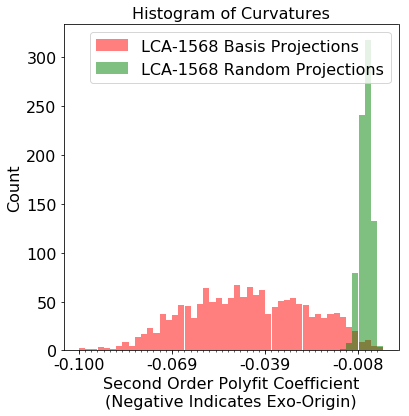

In [166]:
from matplotlib.ticker import FormatStrFormatter

curvatures_768 = np.stack(coeffs, axis=0)[:,2]
rand_curvatures_768 = np.stack(rand_coeffs, axis=0)[:,2]

num_bins = 50
#bins = np.linspace(np.amin([np.amin(curvatures), np.amin(curvatures_768), np.amin(rand_curvatures), np.amin(rand_curvatures_768)]),
#  np.amax([np.amax(curvatures), np.amax(curvatures_768), np.amax(rand_curvatures), np.amax(rand_curvatures_768)]), num_bins)
bins = np.linspace(-0.1,#np.amin([np.amin(curvatures), np.amin(curvatures_768), np.amin(rand_curvatures), np.amin(rand_curvatures_768)]),
  0.0, num_bins)
hist_768, bin_edges = np.histogram(curvatures_768.flatten(), bins)
rand_hist_768, _ = np.histogram(rand_curvatures_768.flatten(), bins)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2

fig, ax = plt.subplots(1, figsize=(6,6))

ax.bar(bin_centers, hist, width=0.002, log=False, color="r", alpha=0.5, align="center", label="LCA-1568 Basis Projections")
ax.bar(bin_centers, rand_hist, width=0.002, log=False, color="g", alpha=0.5, align="center", label="LCA-1568 Random Projections")
#ax.bar(bin_centers, hist_768, width=0.002, log=False, color="b", alpha=0.5, align="center", label="LCA-768 Basis Projections")
#ax.bar(bin_centers, rand_hist_768, width=0.002, log=False, color="k", alpha=0.5, align="center", label="LCA-768 Random Projections")

#ax.plot(bin_centers, hist, color="r", alpha=0.5, linestyle="--", drawstyle="steps-mid", label="LCA-1568 Basis Projections")
#ax.plot(bin_centers, rand_hist, color="g", alpha=0.5, linestyle="--", drawstyle="steps-mid", label="LCA-1568 Random Projections")
#ax.plot(bin_centers, hist_768, color="b", alpha=0.5, linestyle="--", drawstyle="steps-mid", label="LCA-768 Basis Projections")
#ax.plot(bin_centers, rand_hist_768, color="k", alpha=0.5, linestyle="--", drawstyle="steps-mid", label="LCA-768 Random Projections")

ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::15], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.3f"))
for tick in ax.xaxis.get_major_ticks():
  tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(16) 

ax.set_title("Histogram of Curvatures", fontsize=16)
ax.set_xlabel("Second Order Polyfit Coefficient\n(Negative Indicates Exo-Origin)", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.legend(fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/histogram_of_curvatures_bf0id"+str(bf_id0)+".png", transparent=True,
  bbox_inches="tight", pad_inches=0.01)
plt.show()

In [98]:
concavity = np.asarray([np.sign(coeffs[idx][2]) for idx in range(len(coeffs))])
num_endo = np.sum(concavity>0)
endo_indices = np.where(concavity>0)[0]
num_exo = np.sum(concavity<0)
exo_indices = np.where(concavity<0)[0]
print("num >0 (tolerant/invariant/endo-origin):", num_endo,
  "\nnum <0 (selective/equivariant/exo-origin):", num_exo)

num >0 (tolerant/invariant/endo-origin): 0 
num <0 (selective/equivariant/exo-origin): 1567


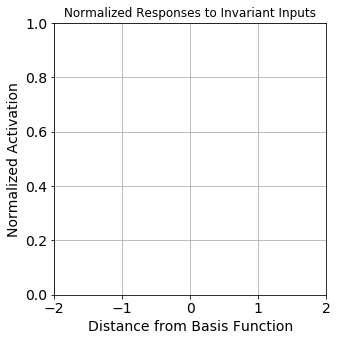

In [99]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for idx in endo_indices:
  ax.plot(pop_proj_datapoints[:,1], fits[idx], color="g", alpha=0.3)
ax.set_title("Normalized Responses to Invariant Inputs")
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0,1.0])
ax.set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax.set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/fit_invariant_curvatures.png")
plt.show()

In [100]:
max_exo_index = np.argmin(concavity) # image index with the maximum exo-origin curviture
max_endo_index = np.argmax(concavity) # image index with the maximum endo-origin curviture

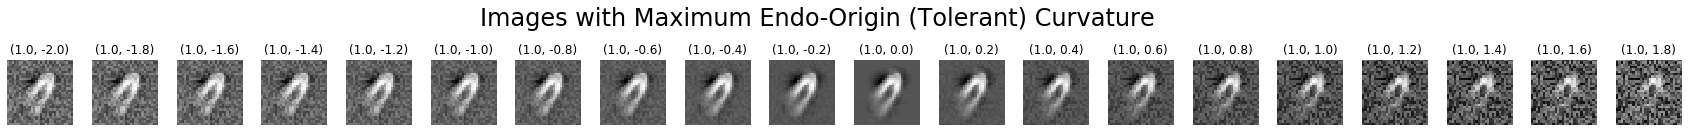

In [168]:
num_comparison_points = 20
num_plots_y = 1
num_plots_x = num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(30, 6))

y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
if y_indices.size < num_comparison_points:
  y_indices.append(-1)
for pid, xid in enumerate(range(num_plots_x)):
  ax = pf.clear_axis(fig.add_subplot(gs1[0, xid]))
  imid = np.ravel_multi_index((max_endo_index, y_indices[pid]), (num_orthogonal, pop_num_imgs))
  ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([int(np.sqrt(analyzer.model_params.num_pixels)),
    int(np.sqrt(analyzer.model_params.num_pixels))]), cmap="Greys_r")
  subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
    +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
  ax.set_title(subfig_title)
fig.suptitle("Images with Maximum Endo-Origin (Tolerant) Curvature", fontsize=24, y=0.7)
fig.savefig(analyzer.analysis_out_dir+"/vis/max_endo_images.png")
plt.show()

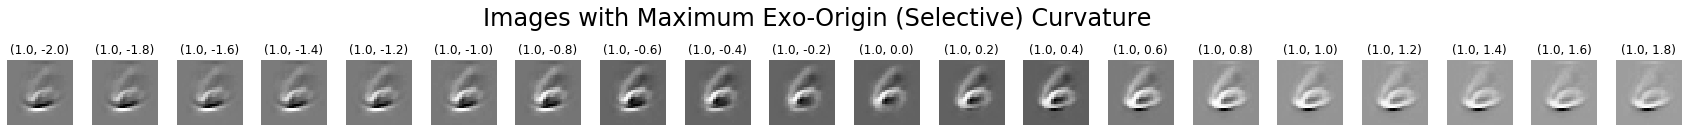

In [78]:
num_comparison_points = 20
num_plots_y = 1
num_plots_x = num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(30, 6))

y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
if y_indices.size < num_comparison_points:
  y_indices.append(-1)
for pid, xid in enumerate(range(num_plots_x)):
  ax = pf.clear_axis(fig.add_subplot(gs1[0, xid]))
  imid = np.ravel_multi_index((max_exo_index, y_indices[pid]), (num_orthogonal, pop_num_imgs))
  ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([int(np.sqrt(analyzer.model_params.num_pixels)),
    int(np.sqrt(analyzer.model_params.num_pixels))]), cmap="Greys_r")
  subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
    +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
  ax.set_title(subfig_title)
fig.suptitle("Images with Maximum Exo-Origin (Selective) Curvature", fontsize=24, y=0.7)
fig.savefig(analyzer.analysis_out_dir+"/vis/max_exo_images.png")
plt.show()